### Описание проекта
Задача проекта сегментировать покупателей по профилю потребления
- Проведем исследовательский анализ данных
- Сегментируем покупателей на основе истории их покупок
- Сформулируем и проверим статистические гипотезы

### Описание данных
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [1]:
# Библиотеки
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
from io import BytesIO
import requests
import re
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from numpy import arange
import seaborn as sns
import plotly.express as px


In [2]:
#https://docs.google.com/spreadsheets/d/1Q090KHdj0qMsDbCN1EU-NA_jD258A9V8ykkUvKcgqzo/edit?usp=sharing
    
spreadsheet_id = '****'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))

In [3]:
# Основная информация о таблице
display(data.sample(10))

,date,customer_id,order_id,product,quantity,price
4243,2019060120,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Патиссона сорт Диск, кассета по 6шт",1,120.0
4412,2019060320,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Аэронавт, кассета по 6шт",1,120.0
857,2018111901,9a8972d8-29a3-48c8-beda-f60eeb0b98a8,69044,Сумка-тележка DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,1,712.0
5947,2019072412,1ea5e4d7-585a-4295-8d2c-09e3045c0125,14906,Пеларгония зональная диам. 12 см сиреневый полумахровый,1,188.0
6081,2019081216,799b66e1-a47e-4143-8167-8bf434651e83,72267,Искусственный цветок Роза открытая малая пластиковая красная,4,29.0
1182,2018121214,c5a58955-4352-4d1c-bb4e-16ca0a94bc6f,14516,Ель канадская Коника ртк 303 горшок 9 л Нидерланды,1,232.0
2878,2019041613,0184f535-b60a-4914-a982-231e3f615206,14649,"Калибрахоа Bloomtastic Blossom розово-сиреневая объем 0,5 л",1,90.0
6601,2019101315,b1dbc7c4-3c84-40a7-80c9-46e2f79d24ad,72950,Кастрюля эмалированная Стэма С-1624 12 л цилиндрическая без рисунка 1506037,1,974.0
1906,2019021914,353d3da0-5399-4939-a860-a0e0849446dc,70353,"Коврик придверный влаговпитывающий Hello, Bonjour, Ciao из переработанной резины и коврового покрытия 60х90 см, Apache, 4658",1,1649.0
3022,2019042215,97f94402-66c0-4995-b8d7-adb33eda71c8,14671,томата (помидор) Минусинские № 94 сорт индетерминантный среднеспелый розовый,5,38.0


In [4]:
# Основная информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [5]:
# Проверка дубликатов
print(data.duplicated().sum())

0


In [6]:
# Изменим формат `date` и разделим дату и время на 2 столбца
data['date'] = pd.to_datetime(data['date'], format = '%Y%m%d%H')
data['time'] = data['date'].dt.hour
data['date'] = data['date'].dt.date
display(data.sample(10))

,date,customer_id,order_id,product,quantity,price,time
4665,2019-06-05,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Золотинка кассета 6 шт E6,1,120.0,22
1754,2019-02-09,4a5956df-79b0-4825-9863-864919eb9628,14535,Пеларгония зональная РОЗОЦВЕТНАЯ Маргарита лососевая 5-7 листов,4,90.0,12
2301,2019-03-12,9cafc2fa-f633-4aca-96aa-ac78269a9f26,70709,"Таз пластмассовый со стиральной доской (Иж), 1404021",1,397.0,19
4764,2019-06-07,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Горный, кассета по 6шт",1,120.0,10
5129,2019-06-11,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Золотинка кассета 6 шт E6,1,120.0,17
3403,2019-05-05,71fa654e-ce06-4cf3-bafd-2884649f23e5,71353,Стремянка Framar Slimmy стальная 3 ступени,1,1574.0,10
4018,2019-05-24,f9ba8b01-2f9d-493e-ae11-2d470a39502a,14814,Рассада Капусты кольраби сорт Венская белая кассета 6 шт E6,1,120.0,10
6367,2019-09-19,de95510f-3558-4c42-97dc-98cc4215c278,72698,"Универсальный нож WEBBER из нержавеющей стали Русские мотивы 12,7 см с деревянной ручкой ВЕ-2252D",80,45.0,16
265,2018-10-15,27a362b3-d62a-4e68-a655-43fc68c818da,68658,Чехол для гладильной доски Zalger 520138 140х50 см металлизированный с поролоном для доски 135х45 см,1,300.0,17
3451,2019-05-08,77b16868-3a9e-4238-a347-db456ccab902,14734,"Рассада зелени для кухни Душица-орегано розовый объем 0,5 л",1,89.0,13


In [7]:
# Редактирование наименования товаров
data['product'] = data['product'].str.lower()
data['product'] = data['product'].replace('tepмокружка avex freeflow 700 мл сталь avex0776', 'тepмокружка avex freeflow 700 мл сталь avex0776')
data['product'] = data['product'].replace('tepмокружка avex recharge 500 мл голубой avex0681', 'тepмокружка avex recharge 500 мл голубой avex0681')
data['product'] = data['product'].replace('tepмокружка avex freeflow 700 мл зеленый avex0759', 'тepмокружка avex freeflow 700 мл зеленый avex0759')


In [8]:
# Проверим предположительно выбросы
display(data[['quantity', 'price']].describe())

,quantity,price
count,6737.000000,6737.000000
mean,2.501559,462.028499
std,15.266478,871.296064
min,1.000000,9.000000
25%,1.000000,101.000000
50%,1.000000,135.000000
75%,1.000000,398.000000
max,1000.000000,14917.000000


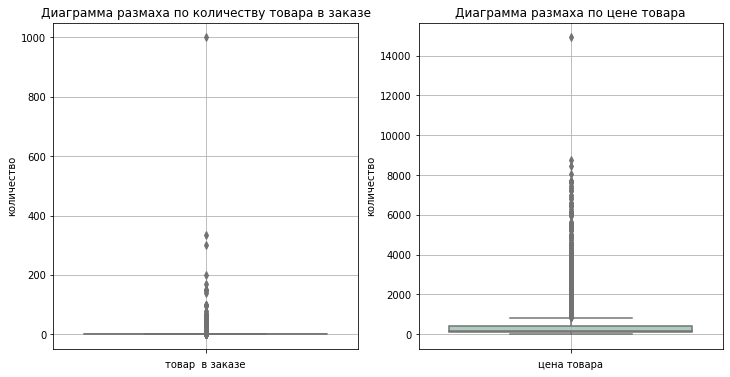

In [9]:
# Диаграммы размаха
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
ax = sns.boxplot( y='quantity', data=data, color='#AAD1C0')
ax.set_title('Диаграмма размаха по количеству товара в заказе')
ax.set_xlabel('товар  в заказе')
ax.set_ylabel('количество')
ax.grid(True)
fig.add_subplot(1, 2, 2)
ax = sns.boxplot( y='price', data=data, color='#AAD1C0')
ax.set_title('Диаграмма размаха по цене товара')
ax.set_xlabel('цена товара')
ax.set_ylabel('количество')
ax.grid(True)
None

,quantity,price
count,6735.000000,6735.000000
mean,2.353675,459.850631
std,9.238737,853.429716
min,1.000000,9.000000
25%,1.000000,101.000000
50%,1.000000,135.000000
75%,1.000000,397.000000
max,334.000000,8737.000000


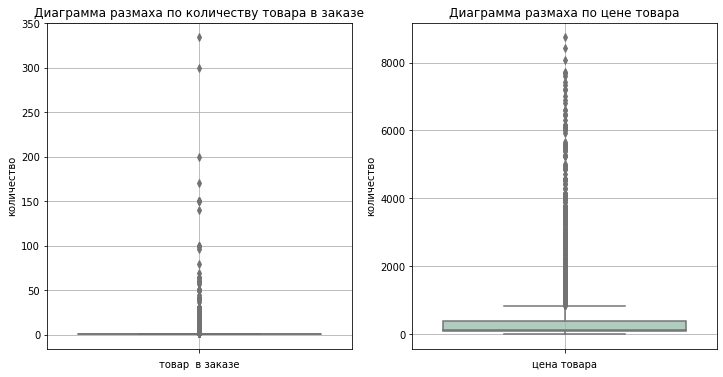

In [10]:
# Избавимся от значительных выбросов
data =  data[(data['price']<9000) & (data['quantity']<350)]
display(data[['quantity', 'price']].describe())

# Повторим диаграммы размаха
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
ax = sns.boxplot( y='quantity', data=data, color='#AAD1C0')
ax.set_title('Диаграмма размаха по количеству товара в заказе')
ax.set_xlabel('товар  в заказе')
ax.set_ylabel('количество')
ax.grid(True)
fig.add_subplot(1, 2, 2)
ax = sns.boxplot( y='price', data=data, color='#AAD1C0')
ax.set_title('Диаграмма размаха по цене товара')
ax.set_xlabel('цена товара')
ax.set_ylabel('количество')
ax.grid(True)
None

### Выводы
Исходные данные состоят из 6 столбцов и 6737 строк, пропуски и дубликаты отсутствуют. При подготовке данных к анализу столбец с датой заказа был разделен на дату и время, отредактированы названия нескольких наименований товаров. В столбцах `price` и `quantity` были обнаружены явные выбросы, от которых пришлось избавиться.

### 2.	Исследовательский анализ данных

#### 2.1.	Определим даты проведения исследования

In [11]:
print('Даты проведения исследования', data['date'].min(), '-', data['date'].max())

Даты проведения исследования 2018-10-01 - 2019-10-31


#### 2.2.	Посмотрим на популярность товаров по категориям

In [12]:
# Редактирование наименования товаров
category = data['product']
m = Mystem()
lemmas=[]
for i in category:
    element = m.lemmatize(i)
    lemmas.append(element)
data['lem_product'] = lemmas

#print(lemmas)

In [13]:
# Словари с распределением ключевых слов по категориям 
plants = ['растение', 'горшок', 'цвести', 'черенок', 'лобелия', 'лилейник', 'тыква', 'сельдерей',
          'рассада', 'зональный', 'цветок', 'муляж', 'виноград', 'арбуз', 'скиммия','кабачок',
          'калибрахоа', 'петуния', 'эхинацея', 'вербена', 'лобелия', 'нолина', 'луковица',
          'томат', 'бакоп', 'пеларгония', 'адиантум','котовник', 'папоротник', 'муррайя',
         'эвкалипт', 'эхеверие', 'суккулент', 'цикламен', 'дыня', 'баклажан', 'аптение',
         'нолина', 'калатея', 'кампануть', 'юкка', 'шеффлер', 'гардения', 'азалия', 'табак',
          'циперус', 'хризолидокарпус', 'радермахер','вербейник', 'энотера', 'артемизия',
          'хризантема', 'фиалка', 'роза', 'мелисса', 'колокольчик', 'платикодон', 'нивянник',
          'душица', 'гербер', 'молодило', 'антуриум', 'овсянница', 'патиссон', 'георгин',
          'афеляндр', 'аспарагус', 'сантолина', 'иссоп', 'виола', 'клубника', 'лист', 'шалфей',
         'кориандр', 'мирт', 'гортензия', 'азалий', 'альбук', 'цитрофортунелла', 'фал',
         'хлорофитум', 'розмарин', 'глоксиния', 'календула', 'фуксия', 'эшшольция', 'лантан',
         'гвоздик', 'капуста', 'косметь', 'кореопсис', 'ясколка', 'калибрахоя', 'смолевка',
         'годеция', 'алиссум',  'лапчатка', 'огурец', 'настурция', 'вероника', 'пеперомия',
         'морковь','бархатцы', 'мимоза', 'калоцефалус', 'капсикум', 'кашпо', 'афеляндра',
         'каллун', 'соланум', 'эшшольций', 'цинерария', 'дендробиум', 'гербера', 'пиретрум',
         'флокс', 'бальзамин', 'бегония', 'лаванда', 'мята', 'каланхое', 'крассула', 'замиокулькас',
         'примула', 'диффенбахий', 'фаленопсис', 'подсолнечник', 'пуансетия', 'цинния',
         'аптений', 'дерево', 'фиттоний', 'тимьян', 'алоэ', 'лиана', 'кофе', 'камнеломка',
         'гимнокалициум', 'спатифиллум', 'пуансеттия', 'скиммий', 'гипсофил', 'эхинокактус',
         'тюльпан', 'эпипремнум', 'аквилегия', 'базилик', 'земляника', 'горох', 'лавр',
         'незабудка', 'седум', 'укроп', 'нефролепис', 'калла', 'чабер', 'ранункулус','салат',
         'импатиенс', 'мединилла', 'зверобой', 'хамедорей', 'вигна', 'петрушка', 'любисток',
         'змееголовник', 'валериана', 'лен', 'анемон', 'лаватер', 'фатсия', 'барвинок', 'бадан',
         'фикус', 'лук', 'джункус', 'драцена', 'хоста', 'гайлардий', 'монард', 'рудбекия',
         'осина', 'трава', 'астра', 'бузульник', 'солидаго', 'физостегия', 'пахира', 'литопс']

kitchen = ['сковорода', 'тарелка', 'ложка', 'салатник', 'тортница', 'отделитель', 
          'банка', 'ковш', 'нож', 'скалка', 'таз', 'блюдо', 'емкость', 'сахарница',
          'чайник', 'толкушка', 'вилка', 'кувшин', 'пищевой', 'орехоколка', 'половник',
         'фужер', 'кружка', 'противень', 'котел', 'термокружок', 'сотейник',
         'посуда', 'овощечистка', 'стакан', 'салфетница','форма', 'бидон', 'соковарка',
          'лопатка', 'терка', 'овощеварка', 'рыбочистка', 'чайный', 'ваза',
          'масленка', 'ножеточка', 'картофелемялка', 'выпечка', 'кухонный',
          'кондитерский', 'бокал', 'мантоварка', 'рассекатель', 'пробка',
          'миска', 'лоток', 'пресс', 'термостакан', 'блюдце', 'бульонница',
          'разделочный', 'хлебница', 'кастрюля', 'просеиватель', 'термос', 'столовый']

household_goods = ['тележка', 'сушилка', 'гладильный', 'глажение', 'пуф',
                   'короб', 'щетка', 'ерш', 'ванный', 'rozenbal','подголовник',
                   'перчатка',  'контейнер', 'чехол', 'микрофибры', 'ванна',
                  'дозатор', 'корзина', 'корзинка','прищепок', 'корыто', 'ключница',
                   'вешалка', 'плечики', 'швабра', 'кофр', 'шпагат', 'совок',
                   'коробка', 'ведро', 'веник',  'туалетный', 'пакет',
                   'подрукавник', 'сметка', 'сидение', 'урна', 'пьезозажигалка',
                  'крючок', 'губка', 'шнур', 'термометр', 'мешок',
                  'мыльница',  'сумка', 'тряпкодержатель', 'насадка']

home = ['простыня', 'скатерть', 'коврик', 'халат', 'наволочка','комод', 
        'плед', 'штора', 'ковер', 'полотенце', 'одеяло', 'ящик','полка',
        'полк',  'подставка',  'стеллаж',  'комод', 'фоторамка', 'обувница',
        'пододеяльник', 'этажерка', 'подушка', 'салфетка', 'наматрасник', 
        'наматрацник', 'покрывало']

household_chemicals = ['паста', 'мыло', 'крем', 'стиральный', 'бензин',
                       'средство', 'пена', 'чистка', 'антижир', 'ополаскиватель', 
                       'белье', 'посудомоечный', 'маска', 'отбеливатель',]

construction_repair = ['стремянка', 'стяжка', 'крепеж', 'петля', 'решетка',
                       'свереть', 'сверло', 'шило', 'сварка', 'пружина',
                      'ручка', 'штангенциркуль', 'измерительный', 'линейка',
                      'уголок', 'завертка', 'фиксатор', 'инструмент']

appliances = ['фен', 'утюг', 'светильник', 'миксер', 'весы', 'электроштопор', 
             'электронный', 'пылесос', 'кипятильник', 'соковыжималка']


In [14]:
# Функция распределения товаров по категориям
def key_purpose(data):   
    element = data['lem_product']
    for i in plants:
        if  i in element:    
            return 'растения'            
    for i in kitchen:
        if  i in element:
            return 'товары для кухни'            
    for i in household_goods:
        if  i in element:
            return 'хозтовары' 
    for i in home:
        if  i in element:
            return 'для дома'
    for i in household_chemicals:
        if  i in element:
            return 'бытовая химия'
    for i in construction_repair:
        if  i in element:
            return 'строительство и ремонт'
    for i in appliances:
        if  i in element:
            return 'бытовая техника'
        
data['category'] = data.apply(key_purpose, axis=1)
data = data.drop(['lem_product'], axis = 1)

In [15]:
display(data.head(10))

,date,customer_id,order_id,product,quantity,price,time,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,растения
5,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,0,растения
6,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,0,растения
7,2018-10-01,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,8,хозтовары
8,2018-10-01,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с614, 1404056",1,269.0,8,товары для кухни
9,2018-10-01,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379,1,674.0,9,хозтовары


In [16]:
category_group = data.groupby('category').agg({'quantity':'sum'}).reset_index().sort_values(by='quantity')

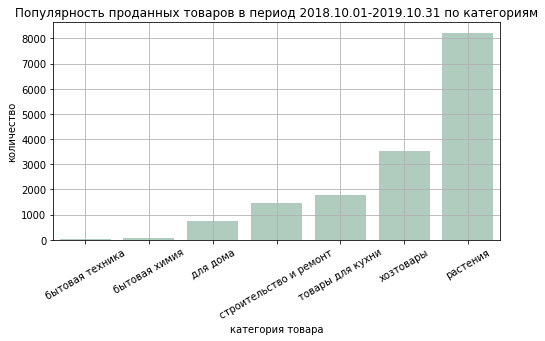

In [17]:
# График
plt.figure(figsize=(8,4))
ax = sns.barplot(x='category', y='quantity', data=category_group, color='#AAD1C0')
ax.set_title('Популярность проданных товаров в период 2018.10.01-2019.10.31 по категориям')
ax.set_xlabel('категория товара')
ax.set_ylabel('количество')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
None


#### Выводы
В рамках исследования товары укрупненно были разделены на 7 категорий (за основу были взяты общероссийские классификаторы продукции). Самой популярной оказалась категория 'растения', меньше всего продаж в категории 'бытовая техника'.

#### 2.3.	Посчитаем минимальный, средний и максимальный чек. Среднее количество товаров в чеке.

In [18]:
# Стоимость каждого заказа
data['coast'] = data['price'] * data['quantity']
recept = data.groupby('order_id')['coast'].sum()
display(recept.head(10))

order_id
12624     375.0
13547    4788.0
14480     359.0
14481     600.0
14482     376.0
14485     676.0
14486    1880.0
14487     514.0
14490     750.0
14494     752.0
Name: coast, dtype: float64

In [19]:
print('Минимальный чек', round(recept.min(),2))
print('Средний чек', round(recept.mean(),2))
print('Медианный чек', round(recept.median(),2))
print('Максимальный чек', round(recept.max(),2))

Минимальный чек 14.0
Средний чек 1495.82
Медианный чек 734.0
Максимальный чек 114750.0


In [20]:
# Количество товаров в чеке
recept_quantity = data.groupby('order_id')['quantity'].sum().mean()
print('Среднее количество товаров в чеке', round(recept_quantity,1))

Среднее количество товаров в чеке 5.7


#### Выводы
- Минимальный чек 14.0
- Средний чек 1495.82
- Медианный чек 734.0
- Максимальный чек 114750.0

Поскольку разброс между суммами чеков достаточно большой, средним чеком будем чситать медианное значение 734р.

Среднее количество товаров в чеке 5.7

####  2.4. Средняя выручка с клиента и среднее количество заказов на 1 клиента

In [21]:
# Средняя выручка с клиента
customer_revenue_mean = data.groupby('customer_id')['coast'].sum().mean()
print('Средняя выручка с клиента', round(customer_revenue_mean,2))

Средняя выручка с клиента 1699.21


In [22]:
# Среднее количество заказов
customer_orders_mean = data.groupby('customer_id')['order_id'].count().mean()
print('Среднее количество заказов на 1 клиента', round(customer_orders_mean,2))

Среднее количество заказов на 1 клиента 2.75


#### 2.5.	Когортный анализ сезонности продаж в популярной категории 'растения'

В процессе исследования были выявлены аномалии в датах заказов. На один заказ приходилось несколько дат оформления. Поскольку доля таких заказов велика, просто избавится от них было бы неправильно. Принято решение для подобных заказов брать самую раннюю дату оформления заказа.

In [23]:
# Получаем список заказов с датами
order_date = data.groupby('order_id').agg({'date' : 'min'}).reset_index()
order_date.head()

,order_id,date
0,12624,2019-06-02
1,13547,2018-10-05
2,14480,2018-10-02
3,14481,2018-10-02
4,14482,2018-10-07
5,14485,2018-10-10
6,14486,2018-10-11
7,14487,2018-10-17
8,14490,2018-10-19
9,14494,2018-10-23


In [24]:
# Добавляем информацию в таблицу
data = data.merge(order_date, on ='order_id' , how = 'left')
data.rename(columns = {'date_x':'date', 'date_y': 'date_edited'}, inplace = True)
data.sample(5)

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited
2538,2019-03-29,e58284ef-20d2-42dd-879d-fdd6bd653f3f,14597,газания рассада однолетних цветов в кассете по 10 шт,1,112.0,14,растения,112.0,2019-03-28
2487,2019-03-28,56f19ebf-c69b-4482-8cda-cc184f16e7f0,14595,"космея снежный клик 0,1 г 4660010770414",2,22.0,10,растения,44.0,2019-03-28
1554,2019-01-20,3ca75ac4-68b2-4d83-99c9-1fdf74ce0575,69890,сушилка для белья напольная ника сбп1/с 18 м,1,599.0,19,хозтовары,599.0,2019-01-20
1174,2018-12-11,c971fb21-d54c-4134-938f-16b62ee86d3b,69307,"штора со встроенными кольцами под штангу для ванны и душа жаккард, полиамидное покрытие, 180х200, бежевый, hsc/st05/beige",1,899.0,13,хозтовары,899.0,2018-12-11
6096,2019-08-15,e7833283-956b-43f0-9a2b-0b71e229c1a1,72297,коврик влаговпитывающий ребристый 60х90 см стандарт черный 5881,2,419.0,9,для дома,838.0,2019-08-15
3783,2019-05-14,dfbcfde5-21de-4504-aff4-453e617d81c1,14774,"рассада зелени для кухни базилик шалун, кассета по 6шт",1,169.0,16,растения,169.0,2019-05-14
6402,2019-09-23,317c2f9e-748a-4e3e-88f7-a93dde8d7467,72726,карниз для ванной комнаты виолет раздвижной 280 см с кольцами белый 2810/6,1,224.0,11,хозтовары,224.0,2019-09-23
6303,2019-09-11,22239abc-ece1-46da-b7bb-e54402d53ab9,72592,сушилка для белья потолочно-настенная gimi lift 120,1,1124.0,21,хозтовары,1124.0,2019-09-11
5012,2019-06-10,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,рассада огурец кристина ячейки по 6 шт е6,1,120.0,10,растения,120.0,2019-05-31
703,2018-11-08,8dbfb5d0-837c-4cb7-a5d9-88ff7ed304e8,68919,муляж баклажан мини 2 шт,10,21.0,16,растения,210.0,2018-11-08


In [25]:
data.groupby('date_edited')[['order_id']].count().sort_values(by = 'order_id', ascending = False).head(10)

,order_id
date_edited,
2019-05-31,1093
2019-05-12,117
2019-07-09,91
2019-04-24,88
2019-05-13,86
2019-04-01,83
2019-03-28,64
2019-05-14,59
2019-04-16,57


In [26]:
# Дата первого заказа каждого клиента
first_order_date_customers  = data.groupby('customer_id').agg({'date_edited' : 'min'}).reset_index()
first_order_date_customers.columns= ['customer_id', 'first_order_date']
first_order_date_customers.head()

,customer_id,first_order_date
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29


In [27]:
# Добавляем столбец с датами первых покупок в основную таблицу
data = data.merge(first_order_date_customers, on = 'customer_id', how = 'left' )
data.sample(5)

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited,first_order_date
1005,2018-11-27,33329f56-595d-496e-95ee-3fc69e73c332,69129,"корзина для белья knit 57 л темно-коричневая, curver, 03676-x59-00",1,1274.0,21,хозтовары,1274.0,2018-11-27,2018-11-27
4284,2019-06-02,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт,1,210.0,8,растения,210.0,2019-05-31,2019-05-31
5956,2019-07-25,e0cb2bf2-0b9a-4249-84f4-1b5d51435a4c,14909,пеларгония зональная диам. 12 см красная махровая,2,150.0,17,растения,300.0,2019-07-25,2019-07-25
1199,2018-12-14,c971fb21-d54c-4134-938f-16b62ee86d3b,69354,"весы напольные механические дельта d-2017 130 кг, 1205224",1,749.0,11,бытовая техника,749.0,2018-12-14,2018-10-01
5853,2019-07-13,00e59a12-06d5-47fc-9a33-bfc53aca1e9f,71967,коврик придверный php srl 40х68 см format mezzaluna 20826 узор 5374,2,899.0,16,для дома,1798.0,2019-07-13,2019-07-13


In [28]:
# Выделим месяц покупок
data['first_order_month'] = data['first_order_date'].astype('datetime64[M]')
data['order_month'] = data['date_edited'].astype('datetime64[M]')
data.sample(5)

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited,first_order_date,first_order_month,order_month
1975,2019-02-23,533fc3fd-9412-49d4-90f5-fd9301dc48b9,14547,рассада зелени для кухни тимьян вульгарис компактус диам. 9 см,1,119.0,18,растения,119.0,2019-02-23,2019-02-23,2019-02-01,2019-02-01
2256,2019-03-09,ed411ae5-99f7-46eb-a310-4c2927369bde,70667,корзина для белья виолет с крышкой ротанг 40 л капучино 1840/19,2,487.0,10,хозтовары,974.0,2019-03-09,2019-03-09,2019-03-01,2019-03-01
6230,2019-09-01,f69cf3e0-6548-4800-b266-139e47877894,72469,"стакан для ванной комнаты darwin hammered керамика 11х8 см черный, spirella, 1015330",1,412.0,15,товары для кухни,412.0,2019-09-01,2019-09-01,2019-09-01,2019-09-01
1031,2018-11-30,3093d7a4-da71-429e-98c6-d456423502de,14513,пеларгония зональная махровая лососевая,1,188.0,11,растения,188.0,2018-11-30,2018-11-30,2018-11-01,2018-11-01
6711,2019-10-29,ea4f913c-20d3-44d2-a3dd-c7c58014243f,73129,чайник заварочный 750 мл webber be-5567 с металлическим фильтром,1,344.0,14,товары для кухни,344.0,2019-10-29,2019-10-29,2019-10-01,2019-10-01


In [29]:
# Формируем таблицу по когортам и месяцам
cohort_grouped = data.query('category =="растения"').groupby(['first_order_month', 'order_month']
                                                            ).agg({'coast': 'sum', 'order_id': 'nunique'})

cohort_grouped.columns = ['revenue', 'number_orders']

cohort_grouped

revenue  number_orders
first_order_month order_month                         
2018-10-01        2018-10-01    59082.0             65
                  2018-11-01     3795.0              5
                  2018-12-01     8222.0             11
                  2019-01-01      636.0              2
                  2019-02-01     1761.0              7
                  2019-03-01     1858.0              5
2018-11-01        2018-11-01    61926.0             63
2018-12-01        2018-12-01    38391.0             63
2019-01-01        2019-01-01    31411.0             41
                  2019-02-01      787.0              1
                  2019-04-01      698.0              1
2019-02-01        2019-02-01    58586.0            105
                  2019-03-01      207.0              3
                  2019-04-01     3206.0              5
2019-03-01        2019-03-01    76172.0            106
                  2019-04-01     5751.0              8
                  2019-05-01     2248.0              2
                  2019-06-01      135.0              1
2019-04-01        2019-04-01   105330.0            130
                  2019-05-01     1596.0              2
2019-05-01        2019-05-01   271706.0            106
                  2019-06-01     3948.0              3
                  2019-08-01      622.0              2
                  2019-10-01      447.0              1
2019-06-01        2019-06-01    48440.0             64
                  2019-07-01     1359.0              2
2019-07-01        2019-07-01    71901.0             76
                  2019-08-01      896.0              2
                  2019-09-01     2068.0              2
2019-08-01        2019-08-01    22852.0             51
                  2019-10-01      135.0              1
2019-09-01        2019-09-01    26050.0             65
                  2019-10-01      270.0              1
2019-10-01        2019-10-01    44817.0             77

In [30]:
# Изменение количества заказов по месяцам
cohort_grouped_orders = cohort_grouped.pivot_table(index='first_order_month', columns='order_month',
                                                   values='number_orders', aggfunc='mean') 
cohort_grouped_orders = cohort_grouped_orders.fillna(0) 
cohort_grouped_orders

order_month,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
first_order_month,,,,,,,,,,,,,
2018-10-01,65.0,5.0,11.0,2.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-01,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-01,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,0.0,0.0,0.0,41.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,0.0,105.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,0.0,0.0,0.0,0.0,0.0,106.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0
2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,130.0,2.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,3.0,0.0,2.0,0.0,1.0
2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,2.0,0.0,0.0,0.0


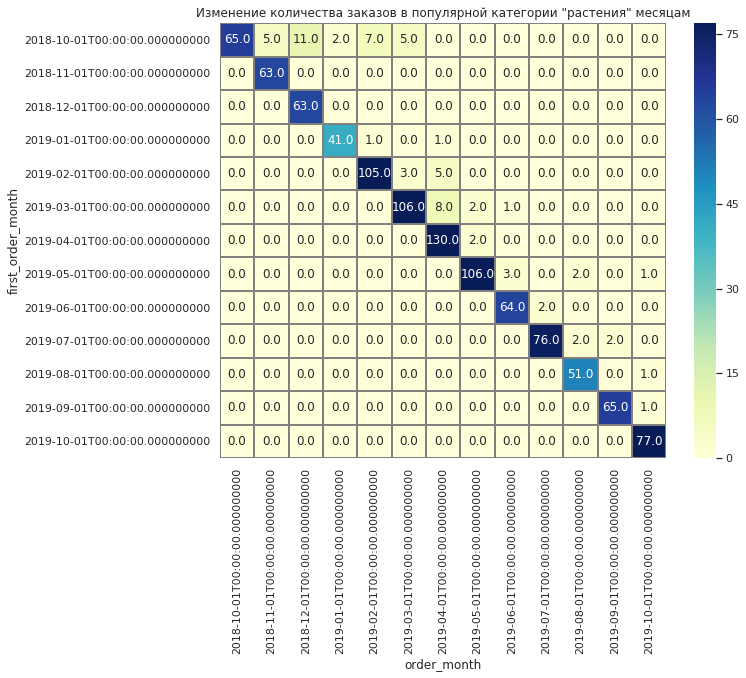

In [31]:
# Тепловая карта
sns.set(style='white')
plt.figure(figsize=(10, 8))
plt.title('Изменение количества заказов в популярной категории "растения" месяцам')
sns.heatmap(cohort_grouped_orders, annot=True, linewidths=1, linecolor='gray', cmap="YlGnBu",fmt='.1f', vmin=0, vmax = 77 );
None

<font color=orange> Роман, подскажи можно ли как-то изменить формат подписи месяцев на графике тепловой карты? Хочется более этсетический вид.

In [32]:
# Изменение среднего чека по месяцам
cohort_grouped_revenue= cohort_grouped.pivot_table(index='first_order_month', columns='order_month',
                                                   values='revenue', aggfunc='mean') 
cohort_grouped_revenue = cohort_grouped_revenue.fillna(0) 
cohort_grouped_revenue

order_month,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
first_order_month,,,,,,,,,,,,,
2018-10-01,59082.0,3795.0,8222.0,636.0,1761.0,1858.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-11-01,0.0,61926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-01,0.0,0.0,38391.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01,0.0,0.0,0.0,31411.0,787.0,0.0,698.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-01,0.0,0.0,0.0,0.0,58586.0,207.0,3206.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-01,0.0,0.0,0.0,0.0,0.0,76172.0,5751.0,2248.0,135.0,0.0,0.0,0.0,0.0
2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,105330.0,1596.0,0.0,0.0,0.0,0.0,0.0
2019-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271706.0,3948.0,0.0,622.0,0.0,447.0
2019-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48440.0,1359.0,0.0,0.0,0.0


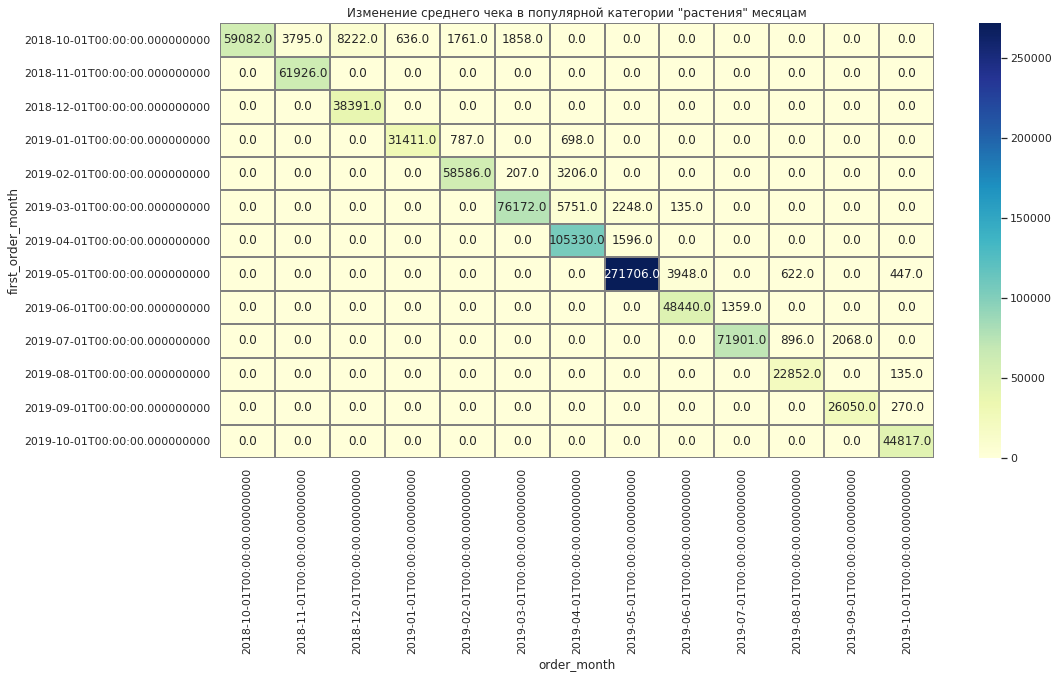

In [33]:
# Тепловая карта
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Изменение среднего чека в популярной категории "растения" месяцам')
sns.heatmap(cohort_grouped_revenue, annot=True, linewidths=1, linecolor='gray', cmap="YlGnBu",fmt='.1f');
None

#### Выводы
В процессе исследования были выявлены аномалии в датах заказов. На один заказ приходилось несколько дат оформления. Поскольку доля таких заказов велика, просто избавится от них было бы неправильно. Принято решение для подобных заказов брать самую раннюю дату оформления заказа. 
Для более четкой картины сделаны 2 сводне таблицы и 2 тепловые карты по когортному анализу:
- изменение количества заказов по месяцам
- изменение среднего чека по месяцам

В обеих тепловых картах сезонность не наблюдается. Покупатели чаще всего не возвращаются, постоянные покупатели как таковые отсутствуют. Только в первой когорте октября 2018 покупки делаются в течении первых 6 месяцев, в  остальных когортах ситуация хуже. Также стоит отметить, что количество заказов и средний чек изменяются скачками.  Возможно для данного исследования не хватило количество данных и стоит повторить анализ с увеличенным временным интервалом(например 2-3 года).

### 3. Сегментируем покупателей на основе истории их покупок

#### 3.1. Сегментируем по частоте заказов

In [34]:
# дата "первого заказа"
frequency_orders_min = data.groupby('customer_id').agg({'date_edited':'min'})
frequency_orders_min.columns = ['date_min']

# дата "последнего заказа"
frequency_orders_max = data.groupby('customer_id').agg({'date_edited':'max'})
frequency_orders_max.columns = ['date_max']

# количество заказов в пределах исследуемого периода
frequency_orders_nun = data.groupby('customer_id').agg({'date_edited':'nunique'})
frequency_orders_nun.columns = ['date_number']

# сводная таблица
frequency_orders = frequency_orders_min.join(frequency_orders_max, on='customer_id')
frequency_orders = frequency_orders.join(frequency_orders_nun, on='customer_id')




In [35]:
# средняя частота заказов
frequency_orders['frequency_orders_days'] = frequency_orders['date_max'].astype('datetime64[D]'
                                            ) - frequency_orders['date_min'].astype('datetime64[D]')
                                            

frequency_orders['frequency_orders_days'] = (frequency_orders['frequency_orders_days']/np.timedelta64(1, 'D')
                                            ).astype('int')
#frequency_orders['frequency_orders_days'] = frequency_orders['frequency_orders_days'].astype('int')

frequency_orders.sample(10)

,date_min,date_max,date_number,frequency_orders_days
customer_id,,,,
89026844-d7a7-4610-9dd6-5fb396c16750,2019-09-22,2019-09-22,1,0
07e68a7f-22ed-4c8a-b0d1-79ba886a1be0,2019-10-16,2019-10-16,1,0
17a37fc5-4b01-4cb9-af2d-d4c89d122135,2019-01-10,2019-01-10,1,0
6701b881-67ae-49b3-a849-316b5cc3439e,2019-07-16,2019-07-16,1,0
344aa778-e436-419e-a9c6-9b8f37b7c1df,2019-10-30,2019-10-30,1,0
b672d861-071d-4435-b683-09403130a52e,2019-02-27,2019-02-27,1,0
f033f8bb-1714-4bb8-8369-4a5b4ebc7216,2018-12-02,2018-12-02,1,0
19bf691d-c946-4de7-a2f3-5e646ee8bba3,2018-12-15,2018-12-15,1,0
b23ee66f-6ae3-4462-a8d8-7071d03b3214,2019-05-30,2019-05-30,1,0


In [36]:
#print(frequency_orders.groupby('frequency_orders_days')['date_min'].count())

In [37]:
def frequency (data):   
    element = data['frequency_orders_days']
    if  element == 0:    
            return 'раз в год'
    if  element > 0:    
            return 'несколько раз в год'
   
        
frequency_orders['frequency_cat'] = frequency_orders.apply(frequency, axis=1)
frequency_orders.head()

,date_min,date_max,date_number,frequency_orders_days,frequency_cat
customer_id,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16,2019-10-16,1,0,раз в год
001cee7f-0b29-4716-b202-0042213ab038,2019-02-16,2019-02-16,1,0,раз в год
00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14,2019-10-14,1,0,раз в год
002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27,2019-01-27,1,0,раз в год
003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29,2019-09-29,1,0,раз в год


In [38]:
# Добавим сегментацию в основную твблицу
frequency_orders_cat = frequency_orders['frequency_cat'].reset_index()
data = data.merge(frequency_orders_cat, on = 'customer_id', how ='left')
display(data.head(10))

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited,first_order_date,first_order_month,order_month,frequency_cat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,растения,142.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,0,растения,194.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,растения,179.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
5,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d-9 см,1,164.0,0,растения,164.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
6,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d-12 см h-25-35 см,1,134.0,0,растения,134.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
7,2018-10-01,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,8,хозтовары,824.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
8,2018-10-01,6644e5b4-9934-4863-9778-aaa125207701,68478,"таз пластмассовый 21,0 л круглый ""водолей"" с614, 1404056",1,269.0,8,товары для кухни,269.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год
9,2018-10-01,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379,1,674.0,9,хозтовары,674.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,несколько раз в год


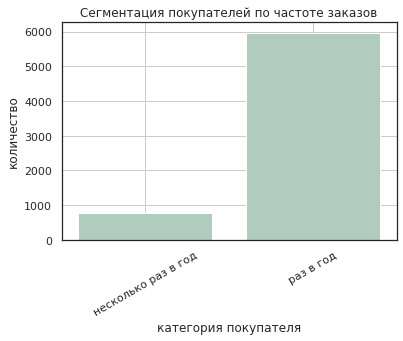

In [39]:
# График
frequency_orders_segment =  data.groupby('frequency_cat')[
    ['customer_id']].count().reset_index().sort_values(by = 'customer_id')
plt.figure(figsize=(6,4))
ax = sns.barplot(x='frequency_cat', y='customer_id', data=frequency_orders_segment, color='#AAD1C0')
ax.set_title('Сегментация покупателей по частоте заказов')
ax.set_xlabel('категория покупателя')
ax.set_ylabel('количество')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
None

#### Выводы
Сегментация клиентов по частоте подтверждает отсутствие как таковых постоянных клиентов и подкрепляет гепотизу об успешном повторении исследования с увеличенным временным интервалом.

#### 3.2. Сегментируем покупателей по средней стоимости заказов

In [40]:
order_price = data.pivot_table(index = ['customer_id','order_id'], 
                               values = 'coast', 
                               aggfunc ='sum').reset_index()

order_price = order_price.groupby('customer_id')[['coast']].mean().reset_index()
display(order_price.head(10))
print(order_price.describe())

,customer_id,coast
0,000d6849-084e-4d9f-ac03-37174eaf60c4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0
5,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,1536.0
6,005ba170-45e8-42de-93f7-192481ae2659,1199.0
7,00bd74b1-2792-47db-a2f1-680a09ac5026,937.0
8,00c0f92a-121a-4883-a78d-2c7b5fe187de,134.0
9,00c95d20-923e-4b45-88fc-53b12931d462,959.0


               coast
count    2449.000000
mean     1496.715865
std      3787.057797
min        14.000000
25%       303.000000
50%       727.000000
75%      1574.000000
max    114750.000000


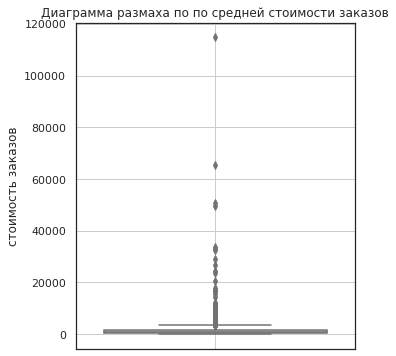

In [41]:
plt.figure(figsize=(5,6))
ax = sns.boxplot( y='coast', data=order_price, color='#AAD1C0')
ax.set_title('Диаграмма размаха по по средней стоимости заказов')
ax.set_ylabel('стоимость заказов')
ax.grid(True)


In [42]:
def order_cost (data):   
    element = data['coast']
    if  element <= 350:    
            return 'маленькие заказы'
    if  element <= 750:    
            return 'средние заказы'
    if  element <= 2000:    
            return 'заказы выше среднего'
    if  element > 2000:    
            return 'большие заказы'
        
order_price['order_cost_cat'] = order_price.apply(order_cost, axis=1)
order_price = order_price.drop('coast', axis=1)
display(order_price.head())

,customer_id,order_cost_cat
0,000d6849-084e-4d9f-ac03-37174eaf60c4,средние заказы
1,001cee7f-0b29-4716-b202-0042213ab038,средние заказы
2,00299f34-5385-4d13-9aea-c80b81658e1b,заказы выше среднего
3,002d4d3a-4a59-406b-86ec-c3314357e498,заказы выше среднего
4,003bbd39-0000-41ff-b7f9-2ddaec152037,большие заказы


In [43]:
# Добавим сегментацию в основную твблицу
data = data.merge(order_price, on = 'customer_id', how ='left')
display(data.head(5))

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited,first_order_date,first_order_month,order_month,frequency_cat,order_cost_cat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,растения,142.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,0,растения,194.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,растения,179.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего


,order_cost_cat,customer_id
2,маленькие заказы,803
3,средние заказы,1077
1,заказы выше среднего,2054
0,большие заказы,2801


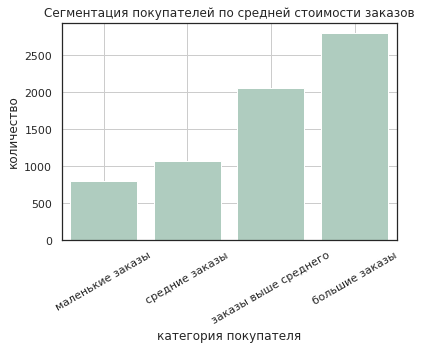

In [44]:
# График
order_cost_segment =  data.groupby('order_cost_cat')[
    ['customer_id']].count().reset_index().sort_values(by = 'customer_id')
display(order_cost_segment)

plt.figure(figsize=(6,4))
ax = sns.barplot(x='order_cost_cat', y='customer_id', data=order_cost_segment, color='#AAD1C0')
ax.set_title('Сегментация покупателей по средней стоимости заказов')
ax.set_xlabel('категория покупателя')
ax.set_ylabel('количество')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
None

#### Выводы
Сегментация клиентов по средней стоимости заказов проводилась с помощью диаграммы размаха и основных статистических данных.
 Всего 4 сегмента:
- заказы до 350р классифицируются как 'маленькие заказы'
- заказы до 750р классифицируются как 'средние заказы'
- заказы до 2000р классифицируются как 'заказы выше среднего'
- заказы свыше 2000р классифицируются как 'большие заказы'

Диаграмма сегментации покупателей показывает, что больше все клиентов с заказами стоимостью свыше 2000р

#### 3.3. Сегментируем по количеству товаров в чеке

In [45]:
order_quantity = data.pivot_table(index = ['customer_id', 'order_id'], 
                               values = 'quantity', 
                               aggfunc = 'sum').reset_index()
order_quantity_segment = order_quantity.groupby('customer_id')[['quantity']].mean()
print(order_quantity_segment['quantity'].describe())
order_quantity_segment.head(10)

count    2449.000000
mean        5.777299
std        26.711215
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       900.000000
Name: quantity, dtype: float64


,quantity
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,4.0
001cee7f-0b29-4716-b202-0042213ab038,1.0
00299f34-5385-4d13-9aea-c80b81658e1b,2.0
002d4d3a-4a59-406b-86ec-c3314357e498,1.0
003bbd39-0000-41ff-b7f9-2ddaec152037,2.0
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,12.0
005ba170-45e8-42de-93f7-192481ae2659,1.0
00bd74b1-2792-47db-a2f1-680a09ac5026,1.0
00c0f92a-121a-4883-a78d-2c7b5fe187de,1.0


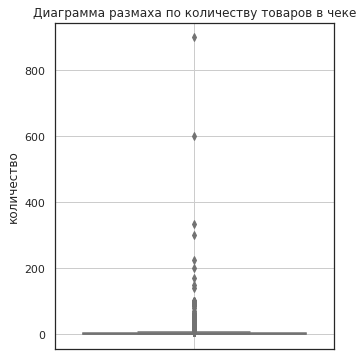

In [46]:
plt.figure(figsize=(5,6))
ax = sns.boxplot( y='quantity', data=order_quantity_segment, color='#AAD1C0')
ax.set_title('Диаграмма размаха по количеству товаров в чеке')
ax.set_ylabel('количество')
ax.grid(True)


In [47]:
def products_number (data):   
    element = data['quantity']
    if  element <= 1:    
            return 'маленькие заказы'
    if  element <= 3:    
            return 'средние заказы'
    if  element <= 100:    
            return 'заказы выше среднего'
    if  element > 100:    
            return 'большие заказы'
        
order_quantity_segment['products_number_cat'] = order_quantity_segment.apply(products_number, axis=1)
order_quantity_segment = order_quantity_segment.drop('quantity', axis=1)
order_quantity_segment.head()

,products_number_cat
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,заказы выше среднего
001cee7f-0b29-4716-b202-0042213ab038,маленькие заказы
00299f34-5385-4d13-9aea-c80b81658e1b,средние заказы
002d4d3a-4a59-406b-86ec-c3314357e498,маленькие заказы
003bbd39-0000-41ff-b7f9-2ddaec152037,средние заказы


In [48]:
# Добавим сегментацию в основную твблицу
data = data.merge(order_quantity_segment, on = 'customer_id', how ='left')
display(data.head())

,date,customer_id,order_id,product,quantity,price,time,category,coast,date_edited,first_order_date,first_order_month,order_month,frequency_cat,order_cost_cat,products_number_cat
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,0,растения,142.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего,заказы выше среднего
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12, h25",1,194.0,0,растения,194.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего,заказы выше среднего
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего,заказы выше среднего
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,0,растения,179.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего,заказы выше среднего
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,0,растения,112.0,2018-10-01,2018-10-01,2018-10-01,2018-10-01,раз в год,заказы выше среднего,заказы выше среднего


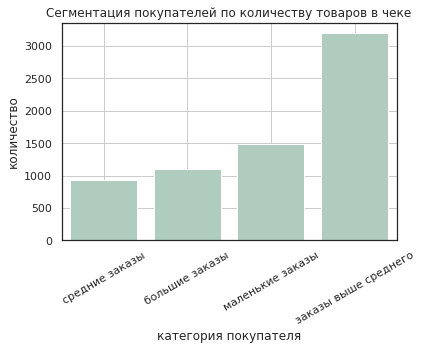

In [49]:
# График
order_cost_segment =  data.groupby('products_number_cat')[
    ['customer_id']].count().reset_index().sort_values(by = 'customer_id')
plt.figure(figsize=(6,4))
ax = sns.barplot(x='products_number_cat', y='customer_id', data=order_cost_segment, color='#AAD1C0')
ax.set_title('Сегментация покупателей по количеству товаров в чеке')
ax.set_xlabel('категория покупателя')
ax.set_ylabel('количество')
ax.grid(True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
None

#### Выводы
Сегментация клиентов по количеству товаров в чеке проводилась с помощью диаграммы размаха и основных статистических данных.
 Всего 4 сегмента:
- заказы с 1 товаром в чеке классифицируются как 'маленькие заказы'
- заказы до 3 товаров в чеке классифицируются как 'средние заказы'
- заказы до 100 товаров в чеке классифицируются как 'заказы выше среднего'
- заказы свыше 100 товаров в чеке классифицируются как 'большие заказы'

Диаграмма сегментации покупателей показывает, что больше все клиентов с заказами от 4 до 100 товаров в чеке

### 4. Проверим гипотезу 'средняя выручка от категории "растения"  отличается от суммарной средней выручки  других категорий'
- гипотеза H0 — доли равны
- гипотеза H1 — доли отличаются

In [50]:
test_group = data[['order_id','category','coast']]
test_group_1 = test_group.query('category == "растения"')
test_group_1 = test_group_1['coast']
test_group_several = test_group.query('category != "растения"')
test_group_several = test_group_several['coast']

In [51]:
#проверка количества элементов в выборке
print('Кол-во элементов в выборке категории "растения"',len(test_group_1)) 
print('Кол-во элементов в выборке суммарной выручки других категорий',len(test_group_several)) 
print()

# Дисперсии выборок
disp_test_group_1 = np.var(test_group_1, ddof=1)
print('Дисперсия выборки категории "растения"',disp_test_group_1) 

disp_test_group_several = np.var(test_group_several, ddof=1)
print('Дисперсия выборки суммарной выручки других категорий',disp_test_group_several) 


Кол-во элементов в выборке категории "растения" 4399
Кол-во элементов в выборке суммарной выручки других категорий 2336

Дисперсия выборки категории "растения" 241662.87511031542
Дисперсия выборки суммарной выручки других категорий 5082276.313213899


In [52]:
# Проверка гипотезы

alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(test_group_1, test_group_several, equal_var = False )

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  3.361869199541441e-118
Отвергаем нулевую гипотезу


#### Выводы
Для проверки гипотезы были взяты 2 выборки: выборка по категории товаров 'растения' и суммарная выборка по всем остальным категориям товаров. Дисперсии выборок сильно отличаются, поэтому при проверке гепотизы t-тестом дополнительно указываем параметр  equal_var. В результате проверки нулевая гипотеза опровергнута, средняя выручка от категории "растения" отличается от суммарной средней выручки других категорий.

### 5. Дашборд

[Дашборд](https://public.tableau.com/profile/aksinya6112#!/vizhome/graduation_16218006631210/Dashboard1?publish=yes)
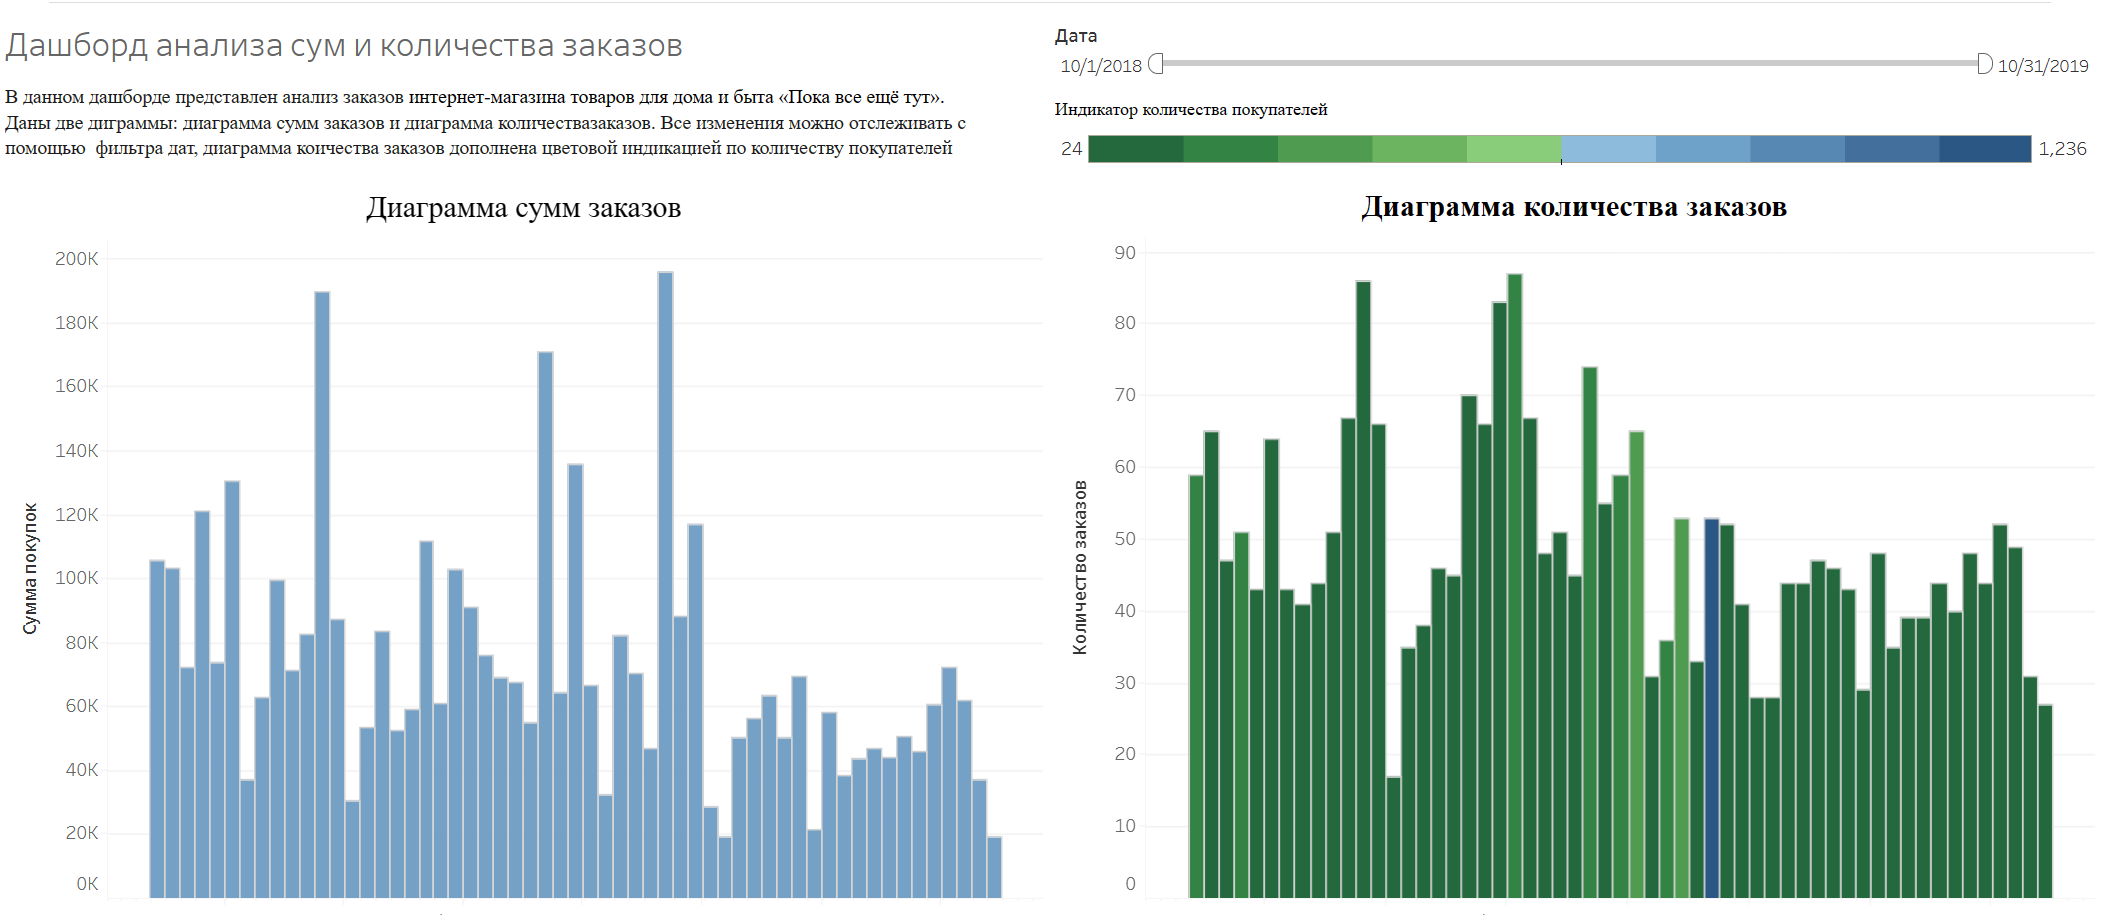

### 6. Презентация

[Презентация](https://drive.google.com/file/d/1R3VKSBjI8JnlHb5sCwK90ijyMq4hfeDz/view?usp=sharing)

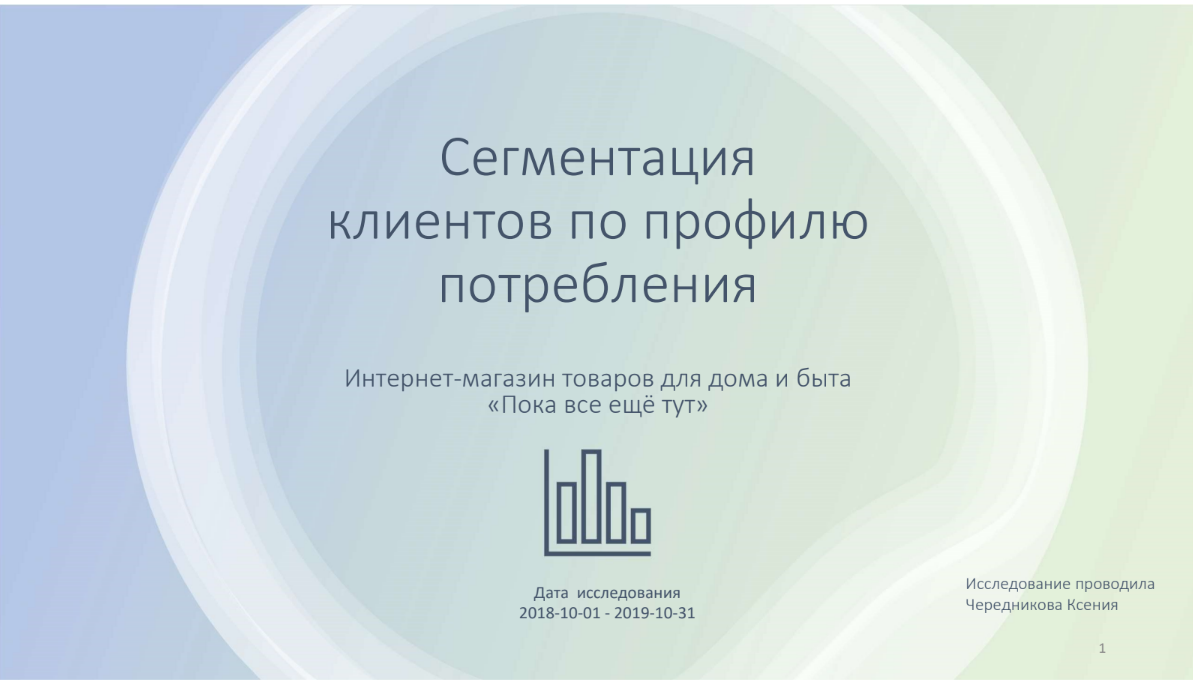

### Выводы и рекомендации

Задачей проекта была сегментировать покупателей. Исследование проводилось на данных 2018-10-01 - 2019-10-31. 
Подведем итоги:
- сегментация клиентов по частоте заказов показала отсутствие постоянных покупателей
- сегментация клиентов по средней стоимости заказа говорит о том, что больше всего клиентов с заказами стоимостью свыше 2000р
- сегментация клиентов по количеству товаров в чеке говорит о том, что больше всего клиентов с заказами от 4 до 100 товаров в чеке
- сегментация клиентов по категории товаров утверждает, что магазин специализируется в основном на продаже товаров категории 'растения'

В рамках исследования был создан дашборд для возможного интерактивного отслеживания ситации по суммам и количествам заказов с учетом дат.

Рекомендуется повторить анализ с увеличенным временным интервалом с учетом специфики магазина, взять интервал исследования 2-3 года.